# My attempt of creating a MLP neural network for predicting the flag.

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from sklearn.metrics import f1_score, accuracy_score

### Let's define constants for this code

In [237]:
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

model_1_loss_and_acc = pd.DataFrame()
model_1_loss_and_acc['train_loss'] = []
model_1_loss_and_acc['train_acc'] = []
model_1_loss_and_acc['test_loss'] = []
model_1_loss_and_acc['test_acc'] = []
model_1_loss_and_acc['f1_score'] = []

model_2_loss_and_acc = model_1_loss_and_acc.copy()
model_3_loss_and_acc = model_1_loss_and_acc.copy()

In [238]:
dataset = pd.read_csv("autentykacja_eeg.csv", delimiter=";")
dataset.head()

,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength,Flag
0,785389,114375,57106,37625,24464,17104,15846,8024,45,91,15,1
1,386949,80792,23506,22118,9566,7147,5392,1697,8,42,6,0
2,21453,14085,4756,5062,2176,2117,2867,862,48,66,9,1
3,322637,56936,17810,25793,15870,8050,3621,2100,25,69,8,0
4,19412,12985,6416,6131,7126,7419,2677,1884,80,53,-1,1


In [239]:

def split_data(X, y, test_size, random_state):
    # split the data into training and remaining data
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=1)

    # split the remaining data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=1)

    return X_train, X_test, X_val, y_train, y_test, y_val
    
X = torch.tensor(dataset.loc[:, "Delta": "BlinkStrength"].values, dtype=torch.float32)
y = torch.tensor(dataset.Flag.values, dtype=torch.float32)

X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y, 0.4, 1)

In [240]:
print(f"Shapes\nX_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\nny_test: {y_test.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

Shapes
X_train: torch.Size([3670, 11])
X_test: torch.Size([787, 11])
y_train: torch.Size([3670])
ny_test: torch.Size([787])
X_val: torch.Size([787, 11])
y_val: torch.Size([787])


In [241]:
y_train = y_train.unsqueeze(1)
y_val = y_val.unsqueeze(1)
y_test = y_test.unsqueeze(1)

## Let's create a datasets and proceed so we can make a dataloaders out of them.

In [242]:
def create_dataloader(X, y):
    dataset = TensorDataset(X, y)
    
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    
    )
    print(f"DataLoader length: {len(dataloader)} | Batch Size: {BATCH_SIZE}")
    return dataloader

In [243]:
train_dataloader = create_dataloader(X_train, y_train)
test_dataloader = create_dataloader(X_test, y_test)
val_dataloader = create_dataloader(X_val, y_val)

DataLoader length: 115 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32


## First of all, I'll try to train my neural network on unchanged data.

In [244]:
input = len(dataset.columns.values) - 1
output = 1


class FlagModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.block_1(x)


flag_model_1 = FlagModel(input, 32, output).to(device)
flag_model_1

FlagModel(
  (block_1): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [245]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> [torch.float]:
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def count_correct_predictions(y_true: torch.Tensor, y_pred: torch.Tensor):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(params=flag_model_1.parameters(), lr=LEARNING_RATE)

In [246]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
            #    accuracy_fn,
               device: torch.device = device):
    train_loss, train_hits, train_acc, all_y_true, all_y_pred = 0, 0, 0, [], []
    model.train()

    for batch in data_loader:
        X, y = batch
        X, y = X.to(device), y.to(device)

        logits = model(X)
        pred = torch.round(logits)
        
        loss = loss_fn(logits, y)
        # acc = accuracy_fn(y_true=y, y_pred=pred)
        train_hits += count_correct_predictions(y, pred) # ile poprawnych predykcji zostało dokonanych
            
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # train_acc += acc
        
        all_y_true.extend(y)
        all_y_pred.extend(pred)
        
    total_train_acc = accuracy_fn(torch.Tensor(all_y_true), torch.Tensor(all_y_pred)) 

    return train_loss / len(data_loader.dataset), total_train_acc, # train_acc / len(data_loader.dataset)


In [247]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
            #    accuracy_fn,
               device:torch.device = device):
    model.eval()
    test_loss, test_hits, all_y_true, all_y_pred = 0, 0, [], []
    test_acc = 0
    with torch.inference_mode():
        
        for batch in data_loader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            logits = model(X)
            pred = torch.round(logits)
            # pred = torch.round(logits)
            
            loss = loss_fn(logits, y)
            # acc = accuracy_fn(y_true=y, y_pred=pred)
            # print("ACC: ", acc)

            test_loss += loss.item()
            # test_acc += acc

            test_hits += count_correct_predictions(y, pred) # ile poprawnych predykcji zostało dokonanych
            
            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(pred.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_y_true, all_y_pred, average='macro')
    acc2 = accuracy_fn(torch.Tensor(all_y_true), torch.Tensor(all_y_pred))

    total_test_acc = test_hits / len(val_dataloader.dataset)

    return test_loss / len(data_loader.dataset), acc2, f1



In [248]:

from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start = timer()

torch.manual_seed(42)

def train(model: torch.nn.Module,
         train_data: torch.utils.data.DataLoader,
         test_data: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
        #  accuracy_fn,
         epochs: int,
         device:torch.device = device,
         model_loss_and_acc: pd.DataFrame = None):

   if model_loss_and_acc is None:
       model_loss_and_acc = pd.DataFrame(columns=['train_loss', 'train_acc', 'test_loss', 'test_acc', "f1_score"])

   for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                     data_loader=train_data,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                    #  accuracy_fn=accuracy_fn,
                                     device=device)
        test_loss, test_acc, f1_score = test_step(model=model,
                                     data_loader=test_data,
                                     loss_fn=loss_fn,
                                    #  accuracy_fn=accuracy_fn,
                                     device=device)

        new_row = pd.Series({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc, "f1_score": f1_score})
        model_loss_and_acc.loc[len(model_loss_and_acc.index)] = new_row

        if epoch % 5:
            print(f"\nEpoch: {epoch} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f}% | Test loss: {test_loss} | Test Acc: {test_acc:.5f}%")

   train_time_end = timer()
   print(f"\nTraining was done in {(train_time_end - train_time_start):.5f} seconds")

   return model_loss_and_acc

In [249]:
model_1_loss_and_acc = train(model=flag_model_1,
      train_data=train_dataloader,
      test_data=val_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      # accuracy_fn=accuracy_fn,
      epochs=EPOCHS,
      model_loss_and_acc=model_1_loss_and_acc)

  4%|▍         | 2/50 [00:00<00:13,  3.67it/s]


Epoch: 1 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.02190734372205625 | Test Acc: 62.26175%


  8%|▊         | 4/50 [00:01<00:13,  3.39it/s]


Epoch: 2 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021961680967289732 | Test Acc: 62.26175%

Epoch: 3 | Train Loss: 0.02250 | Train Acc: 59.56403% | Test loss: 0.022016018061050163 | Test Acc: 62.26175%


 10%|█         | 5/50 [00:01<00:11,  3.91it/s]


Epoch: 4 | Train Loss: 0.02247 | Train Acc: 59.56403% | Test loss: 0.0219073441764754 | Test Acc: 62.26175%


 16%|█▌        | 8/50 [00:02<00:09,  4.29it/s]


Epoch: 6 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.02188017574319997 | Test Acc: 62.26175%

Epoch: 7 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.022043185774828607 | Test Acc: 62.26175%


 20%|██        | 10/50 [00:02<00:07,  5.01it/s]


Epoch: 8 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021961680891553207 | Test Acc: 62.26175%

Epoch: 9 | Train Loss: 0.02246 | Train Acc: 59.56403% | Test loss: 0.021907344100738874 | Test Acc: 62.26175%


 24%|██▍       | 12/50 [00:02<00:06,  5.45it/s]


Epoch: 11 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021880175591726923 | Test Acc: 62.26175%


 26%|██▌       | 13/50 [00:03<00:08,  4.41it/s]


Epoch: 12 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021961681194499306 | Test Acc: 62.26175%


 28%|██▊       | 14/50 [00:03<00:09,  3.61it/s]


Epoch: 13 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.02201601783384059 | Test Acc: 62.26175%


 30%|███       | 15/50 [00:03<00:11,  3.17it/s]


Epoch: 14 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021988849362696898 | Test Acc: 62.26175%


 36%|███▌      | 18/50 [00:04<00:07,  4.10it/s]


Epoch: 16 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.02193451245827778 | Test Acc: 62.26175%

Epoch: 17 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021907343797792776 | Test Acc: 62.26175%


 40%|████      | 20/50 [00:04<00:06,  4.78it/s]


Epoch: 18 | Train Loss: 0.02250 | Train Acc: 59.56403% | Test loss: 0.021880175818936493 | Test Acc: 62.26175%

Epoch: 19 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.02193451245827778 | Test Acc: 62.26175%


 44%|████▍     | 22/50 [00:05<00:05,  5.45it/s]


Epoch: 21 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.022070354548918397 | Test Acc: 62.26175%


 48%|████▊     | 24/50 [00:05<00:05,  5.12it/s]


Epoch: 22 | Train Loss: 0.02247 | Train Acc: 59.56403% | Test loss: 0.021934512534014305 | Test Acc: 62.26175%

Epoch: 23 | Train Loss: 0.02247 | Train Acc: 59.56403% | Test loss: 0.021934512534014305 | Test Acc: 62.26175%


 52%|█████▏    | 26/50 [00:05<00:04,  5.63it/s]


Epoch: 24 | Train Loss: 0.02247 | Train Acc: 59.56403% | Test loss: 0.02193451245827778 | Test Acc: 62.26175%


 56%|█████▌    | 28/50 [00:06<00:03,  5.89it/s]


Epoch: 26 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.022043186342852544 | Test Acc: 62.26175%

Epoch: 27 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.021907343949265825 | Test Acc: 62.26175%


 60%|██████    | 30/50 [00:06<00:03,  5.98it/s]


Epoch: 28 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021880175894673018 | Test Acc: 62.26175%

Epoch: 29 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021988849324828637 | Test Acc: 62.26175%


 66%|██████▌   | 33/50 [00:07<00:02,  6.05it/s]


Epoch: 31 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.0219345128369604 | Test Acc: 62.26175%

Epoch: 32 | Train Loss: 0.02247 | Train Acc: 59.56403% | Test loss: 0.021934512382541255 | Test Acc: 62.26175%


 68%|██████▊   | 34/50 [00:07<00:03,  4.93it/s]


Epoch: 33 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.02190734402500235 | Test Acc: 62.26175%


 70%|███████   | 35/50 [00:07<00:03,  4.15it/s]


Epoch: 34 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.021961680740080158 | Test Acc: 62.26175%


 74%|███████▍  | 37/50 [00:08<00:03,  3.34it/s]


Epoch: 36 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021988849552038208 | Test Acc: 62.26175%


 76%|███████▌  | 38/50 [00:08<00:03,  3.16it/s]


Epoch: 37 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.022043186342852544 | Test Acc: 62.26175%


 78%|███████▊  | 39/50 [00:09<00:03,  3.39it/s]


Epoch: 38 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.02193451245827778 | Test Acc: 62.26175%


 82%|████████▏ | 41/50 [00:09<00:02,  3.82it/s]


Epoch: 39 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.02193451245827778 | Test Acc: 62.26175%


 86%|████████▌ | 43/50 [00:09<00:01,  4.20it/s]


Epoch: 41 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.02193451245827778 | Test Acc: 62.26175%

Epoch: 42 | Train Loss: 0.02248 | Train Acc: 59.56403% | Test loss: 0.021880175137307774 | Test Acc: 62.26175%


 88%|████████▊ | 44/50 [00:10<00:01,  4.50it/s]


Epoch: 43 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021961680815816682 | Test Acc: 62.26175%


 90%|█████████ | 45/50 [00:10<00:01,  3.87it/s]


Epoch: 44 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021880175667463447 | Test Acc: 62.26175%


 94%|█████████▍| 47/50 [00:11<00:00,  3.44it/s]


Epoch: 46 | Train Loss: 0.02247 | Train Acc: 59.56403% | Test loss: 0.021907343797792776 | Test Acc: 62.26175%


 96%|█████████▌| 48/50 [00:11<00:00,  2.98it/s]


Epoch: 47 | Train Loss: 0.02249 | Train Acc: 59.56403% | Test loss: 0.021907344100738874 | Test Acc: 62.26175%


 98%|█████████▊| 49/50 [00:11<00:00,  3.17it/s]


Epoch: 48 | Train Loss: 0.02247 | Train Acc: 59.56403% | Test loss: 0.02188017536451735 | Test Acc: 62.26175%


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


Epoch: 49 | Train Loss: 0.02249 | Train Acc: 59.59128% | Test loss: 0.021961680891553207 | Test Acc: 62.26175%

Training was done in 12.31176 seconds


# Since predicting on unchanged data wasn't fruitful I'll try to modify them using log function

In [250]:
dataset.loc[dataset['BlinkStrength'] < 0]

def log_transform(data, col, unchanged):
   new_dataset = pd.DataFrame()
   for colname in col:
        new_dataset[colname + '_log'] = np.log(data[colname]+1)

   new_dataset[unchanged] = data[unchanged]
   new_dataset['Flag'] = data['Flag']
   return new_dataset


transformed_dataset = log_transform(dataset,
                                    ['Delta', 'Theta', 'Alpha_low', 'Alpha_high', 'Beta_low', 'Beta_high', 'Gamma_low', 'Gamma_high'],
                                    ["BlinkStrength", "Attention", "Meditation", "Flag"])
transformed_dataset.describe()
# dataset[["Attention", "Meditation", "BlinkStrength"]]

,Delta_log,Theta_log,Alpha_low_log,Alpha_high_log,Beta_low_log,Beta_high_log,Gamma_low_log,Gamma_high_log,BlinkStrength,Attention,Meditation,Flag
count,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000,5244.000000
mean,12.064500,10.695941,9.355392,9.250890,9.035782,8.828616,8.406818,7.724752,11.547292,51.652365,58.632151,0.601068
std,1.189917,0.825552,0.761348,0.684732,0.668153,0.631344,0.737807,0.716020,14.779718,16.511836,15.025158,0.489725
min,8.430545,8.368229,7.257003,7.109879,7.007601,7.074963,6.326149,5.529429,-1.000000,1.000000,1.000000,0.000000
25%,11.211986,10.105826,8.807921,8.773810,8.601534,8.414274,7.892732,7.246368,-1.000000,40.000000,49.000000,0.000000
50%,12.172185,10.610858,9.293578,9.184099,8.987822,8.794673,8.368229,7.678326,8.000000,52.000000,59.000000,1.000000
75%,13.050982,11.287742,9.841825,9.680828,9.423131,9.195531,8.887480,8.168203,18.000000,63.000000,69.000000,1.000000
max,14.425741,13.445089,12.033842,11.912916,12.027843,12.066293,11.105949,10.232324,100.000000,100.000000,99.000000,1.000000


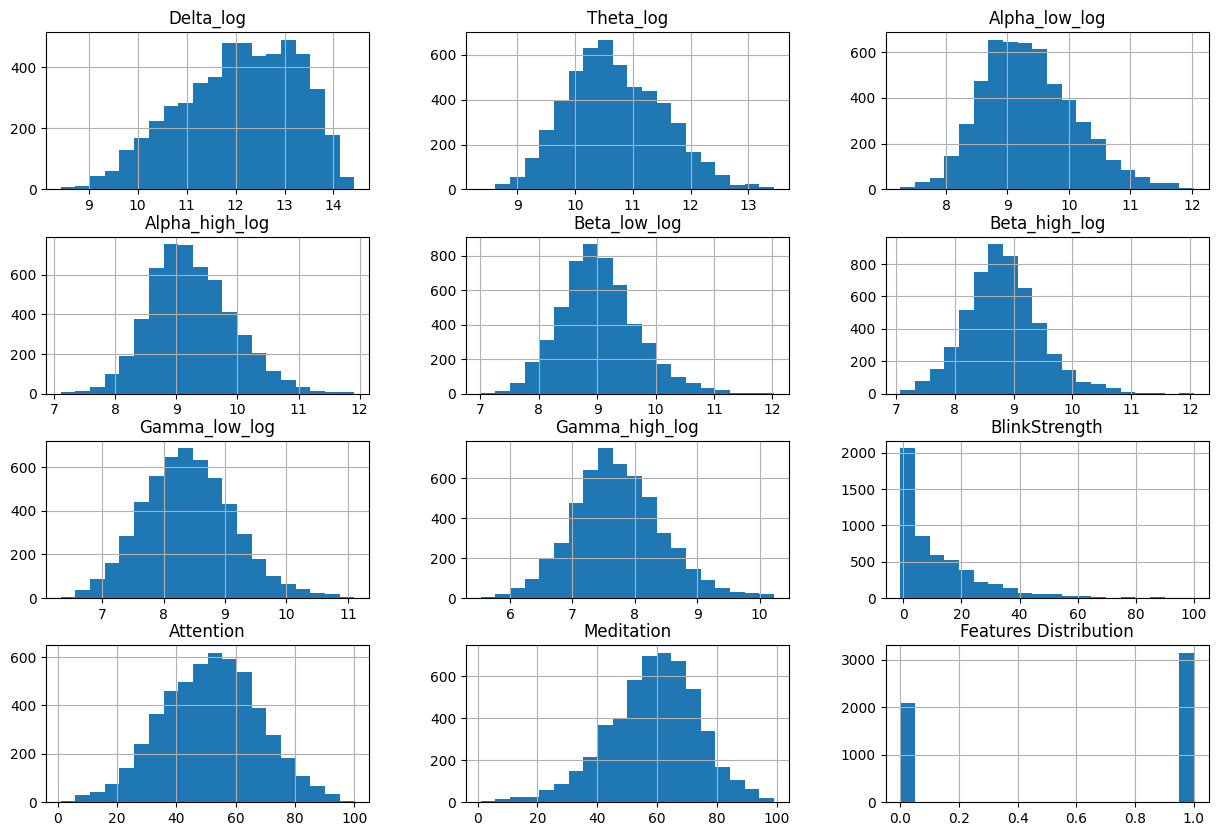

In [251]:
transformed_dataset.hist(figsize=(15,10), bins = 20)
plt.title("Features Distribution")
plt.show()

In [252]:
X2 = torch.tensor(transformed_dataset.loc[:, "Delta_log": "Meditation"].values, dtype=torch.float32)
y2 = torch.tensor(transformed_dataset.Flag.values, dtype=torch.float32)

X_train_2, X_test_2, X_val_2, y_train_2, y_test_2, y_val_2 = split_data(X2, y2, test_size=0.2, random_state=1)

y_train_2 = y_train_2.unsqueeze(1)
y_val_2 = y_val_2.unsqueeze(1)
y_test_2 = y_test_2.unsqueeze(1)

train_dataloader_2 = create_dataloader(X_train_2, y_train_2)
val_dataloader_2 = create_dataloader(X_val_2, y_val_2)
test_dataloader_2 = create_dataloader(X_test_2, y_test_2)

DataLoader length: 115 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32


In [253]:
class FlagModel2(nn.Module):
   def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
       super().__init__()

       self.block_1 = nn.Sequential(
           nn.Linear(in_features=input_shape, out_features=hidden_units),
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=hidden_units),
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=hidden_units),
       )
       self.block_2 = nn.Sequential(
           nn.ReLU(),
           nn.Linear(in_features=hidden_units, out_features=output_shape),
           nn.Sigmoid()
       )

   def forward(self, x):
       return self.block_2(self.block_1(x))

flag_model_2 = FlagModel2(11, 32, 1).to(device)
flag_model_2

FlagModel2(
  (block_1): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (block_2): Sequential(
    (0): ReLU()
    (1): Linear(in_features=32, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [254]:
optimizer = torch.optim.Adam(params=flag_model_2.parameters(), lr=LEARNING_RATE)

In [255]:
model_2_loss_and_acc = train(model=flag_model_2,
      train_data=train_dataloader_2,
      test_data=val_dataloader_2,
      loss_fn=loss_fn,
      optimizer=optimizer,
      # accuracy_fn=accuracy_fn,
      epochs=EPOCHS)

  6%|▌         | 3/50 [00:00<00:10,  4.41it/s]


Epoch: 1 | Train Loss: 0.02051 | Train Acc: 55.80381% | Test loss: 0.02044320295847659 | Test Acc: 55.14612%

Epoch: 2 | Train Loss: 0.02040 | Train Acc: 56.26703% | Test loss: 0.020548221646906308 | Test Acc: 51.58831%


  8%|▊         | 4/50 [00:00<00:09,  4.73it/s]


Epoch: 3 | Train Loss: 0.02035 | Train Acc: 56.56676% | Test loss: 0.02048904286860814 | Test Acc: 53.62135%


 10%|█         | 5/50 [00:01<00:11,  3.85it/s]


Epoch: 4 | Train Loss: 0.02031 | Train Acc: 56.92098% | Test loss: 0.020484784961201184 | Test Acc: 59.84752%


 14%|█▍        | 7/50 [00:02<00:14,  2.97it/s]


Epoch: 6 | Train Loss: 0.02028 | Train Acc: 57.54768% | Test loss: 0.020481941660598697 | Test Acc: 57.56036%


 16%|█▌        | 8/50 [00:02<00:14,  2.85it/s]


Epoch: 7 | Train Loss: 0.02028 | Train Acc: 58.58311% | Test loss: 0.020445464451097926 | Test Acc: 58.57687%


 18%|█▊        | 9/50 [00:02<00:14,  2.82it/s]


Epoch: 8 | Train Loss: 0.02025 | Train Acc: 58.14714% | Test loss: 0.020403505734900507 | Test Acc: 55.65438%


 22%|██▏       | 11/50 [00:03<00:11,  3.31it/s]


Epoch: 9 | Train Loss: 0.02023 | Train Acc: 58.74659% | Test loss: 0.020425974792567716 | Test Acc: 56.54384%


 26%|██▌       | 13/50 [00:03<00:09,  4.09it/s]


Epoch: 11 | Train Loss: 0.02017 | Train Acc: 58.91008% | Test loss: 0.020471164428899975 | Test Acc: 54.63787%

Epoch: 12 | Train Loss: 0.02013 | Train Acc: 60.21798% | Test loss: 0.02044408233526247 | Test Acc: 59.33926%


 28%|██▊       | 14/50 [00:03<00:08,  4.16it/s]


Epoch: 13 | Train Loss: 0.02017 | Train Acc: 58.61035% | Test loss: 0.020429012508828576 | Test Acc: 54.51080%


 30%|███       | 15/50 [00:04<00:08,  4.33it/s]


Epoch: 14 | Train Loss: 0.02015 | Train Acc: 59.42779% | Test loss: 0.020384337577916765 | Test Acc: 56.79797%


 34%|███▍      | 17/50 [00:04<00:10,  3.19it/s]


Epoch: 16 | Train Loss: 0.02013 | Train Acc: 59.59128% | Test loss: 0.02048655121268887 | Test Acc: 53.74841%


 36%|███▌      | 18/50 [00:05<00:10,  2.97it/s]


Epoch: 17 | Train Loss: 0.02011 | Train Acc: 59.72752% | Test loss: 0.020327116058621048 | Test Acc: 59.84752%


 38%|███▊      | 19/50 [00:05<00:10,  2.87it/s]


Epoch: 18 | Train Loss: 0.02013 | Train Acc: 59.59128% | Test loss: 0.020411522521754533 | Test Acc: 59.33926%


 40%|████      | 20/50 [00:05<00:09,  3.26it/s]


Epoch: 19 | Train Loss: 0.02009 | Train Acc: 61.00817% | Test loss: 0.02041313979949854 | Test Acc: 55.01906%


 46%|████▌     | 23/50 [00:06<00:06,  4.28it/s]


Epoch: 21 | Train Loss: 0.02005 | Train Acc: 61.33515% | Test loss: 0.020487349021237868 | Test Acc: 54.12961%

Epoch: 22 | Train Loss: 0.02006 | Train Acc: 60.21798% | Test loss: 0.020419522116417503 | Test Acc: 55.40025%


 50%|█████     | 25/50 [00:06<00:05,  4.79it/s]


Epoch: 23 | Train Loss: 0.02008 | Train Acc: 60.21798% | Test loss: 0.02031115557065913 | Test Acc: 56.79797%

Epoch: 24 | Train Loss: 0.02013 | Train Acc: 59.97275% | Test loss: 0.020427325932164658 | Test Acc: 58.95807%


 54%|█████▍    | 27/50 [00:07<00:04,  5.02it/s]


Epoch: 26 | Train Loss: 0.02008 | Train Acc: 59.83651% | Test loss: 0.020323728136670938 | Test Acc: 57.68742%


 56%|█████▌    | 28/50 [00:07<00:05,  3.98it/s]


Epoch: 27 | Train Loss: 0.02002 | Train Acc: 61.03542% | Test loss: 0.020307327240819094 | Test Acc: 57.94155%


 58%|█████▊    | 29/50 [00:08<00:06,  3.40it/s]


Epoch: 28 | Train Loss: 0.02000 | Train Acc: 61.19891% | Test loss: 0.02039711440533513 | Test Acc: 56.67090%


 60%|██████    | 30/50 [00:08<00:06,  3.15it/s]


Epoch: 29 | Train Loss: 0.02000 | Train Acc: 60.84469% | Test loss: 0.020177226660363708 | Test Acc: 58.19568%


 66%|██████▌   | 33/50 [00:09<00:04,  3.46it/s]


Epoch: 31 | Train Loss: 0.01995 | Train Acc: 62.01635% | Test loss: 0.020293391265893378 | Test Acc: 58.57687%

Epoch: 32 | Train Loss: 0.01997 | Train Acc: 60.76294% | Test loss: 0.0202762122529889 | Test Acc: 57.30623%


 70%|███████   | 35/50 [00:09<00:03,  4.19it/s]


Epoch: 33 | Train Loss: 0.01996 | Train Acc: 61.60763% | Test loss: 0.0203147959981819 | Test Acc: 56.54384%

Epoch: 34 | Train Loss: 0.01996 | Train Acc: 61.33515% | Test loss: 0.020277572783914878 | Test Acc: 57.94155%


 74%|███████▍  | 37/50 [00:10<00:02,  4.63it/s]


Epoch: 36 | Train Loss: 0.01997 | Train Acc: 61.52589% | Test loss: 0.02019210684254027 | Test Acc: 58.06861%


 76%|███████▌  | 38/50 [00:10<00:02,  4.24it/s]


Epoch: 37 | Train Loss: 0.01994 | Train Acc: 61.71662% | Test loss: 0.020110834583999846 | Test Acc: 58.32274%


 78%|███████▊  | 39/50 [00:10<00:03,  3.58it/s]


Epoch: 38 | Train Loss: 0.01999 | Train Acc: 61.11717% | Test loss: 0.02030485270135436 | Test Acc: 57.43329%


 80%|████████  | 40/50 [00:11<00:03,  3.27it/s]


Epoch: 39 | Train Loss: 0.01989 | Train Acc: 61.47139% | Test loss: 0.02017521737036893 | Test Acc: 58.44981%


 86%|████████▌ | 43/50 [00:12<00:02,  3.41it/s]


Epoch: 41 | Train Loss: 0.01997 | Train Acc: 61.22616% | Test loss: 0.020340117823517155 | Test Acc: 55.78145%

Epoch: 42 | Train Loss: 0.01986 | Train Acc: 62.17984% | Test loss: 0.02025627514307199 | Test Acc: 58.57687%


 90%|█████████ | 45/50 [00:12<00:01,  4.16it/s]


Epoch: 43 | Train Loss: 0.01990 | Train Acc: 62.12534% | Test loss: 0.020138801431716473 | Test Acc: 58.83100%

Epoch: 44 | Train Loss: 0.01987 | Train Acc: 62.26158% | Test loss: 0.020212182095877853 | Test Acc: 59.59339%


 96%|█████████▌| 48/50 [00:12<00:00,  4.90it/s]


Epoch: 46 | Train Loss: 0.01993 | Train Acc: 62.31608% | Test loss: 0.02015001392122145 | Test Acc: 61.11817%

Epoch: 47 | Train Loss: 0.01984 | Train Acc: 62.64305% | Test loss: 0.02009241992969828 | Test Acc: 59.84752%


 98%|█████████▊| 49/50 [00:13<00:00,  5.02it/s]


Epoch: 48 | Train Loss: 0.01983 | Train Acc: 62.58856% | Test loss: 0.02009181418897539 | Test Acc: 58.19568%


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Epoch: 49 | Train Loss: 0.01988 | Train Acc: 61.93460% | Test loss: 0.02020270026169405 | Test Acc: 56.54384%

Training was done in 28.48056 seconds


## Maybe scaling my data to make every value to be between 0 and 1 I'll get different results

In [256]:
dataset.head()

,Delta,Theta,Alpha_low,Alpha_high,Beta_low,Beta_high,Gamma_low,Gamma_high,Attention,Meditation,BlinkStrength,Flag
0,785389,114375,57106,37625,24464,17104,15846,8024,45,91,15,1
1,386949,80792,23506,22118,9566,7147,5392,1697,8,42,6,0
2,21453,14085,4756,5062,2176,2117,2867,862,48,66,9,1
3,322637,56936,17810,25793,15870,8050,3621,2100,25,69,8,0
4,19412,12985,6416,6131,7126,7419,2677,1884,80,53,-1,1


In [257]:
max_values = dataset.max()
min_values = dataset.min()
print(max_values, min_values, sep="\t")

scaled_dataset = (dataset - min_values) / (max_values - min_values)

print(scaled_dataset)

Delta            1840855
Theta             690442
Alpha_low         168356
Alpha_high        149180
Beta_low          167349
Beta_high         173909
Gamma_low          66565
Gamma_high         27786
Attention            100
Meditation            99
BlinkStrength        100
Flag                   1
dtype: int64	Delta            4584
Theta            4307
Alpha_low        1417
Alpha_high       1223
Beta_low         1104
Beta_high        1181
Gamma_low         558
Gamma_high        251
Attention           1
Meditation          1
BlinkStrength      -1
Flag                0
dtype: int64
         Delta     Theta  Alpha_low  Alpha_high  Beta_low  Beta_high  \
0     0.425212  0.160417   0.333589    0.246031  0.140516   0.092185   
1     0.208229  0.111472   0.132318    0.141223  0.050901   0.034540   
2     0.009187  0.014251   0.020001    0.025947  0.006448   0.005419   
3     0.173206  0.076704   0.098198    0.166062  0.088821   0.039768   
4     0.008075  0.012648   0.029945    0.033172  0

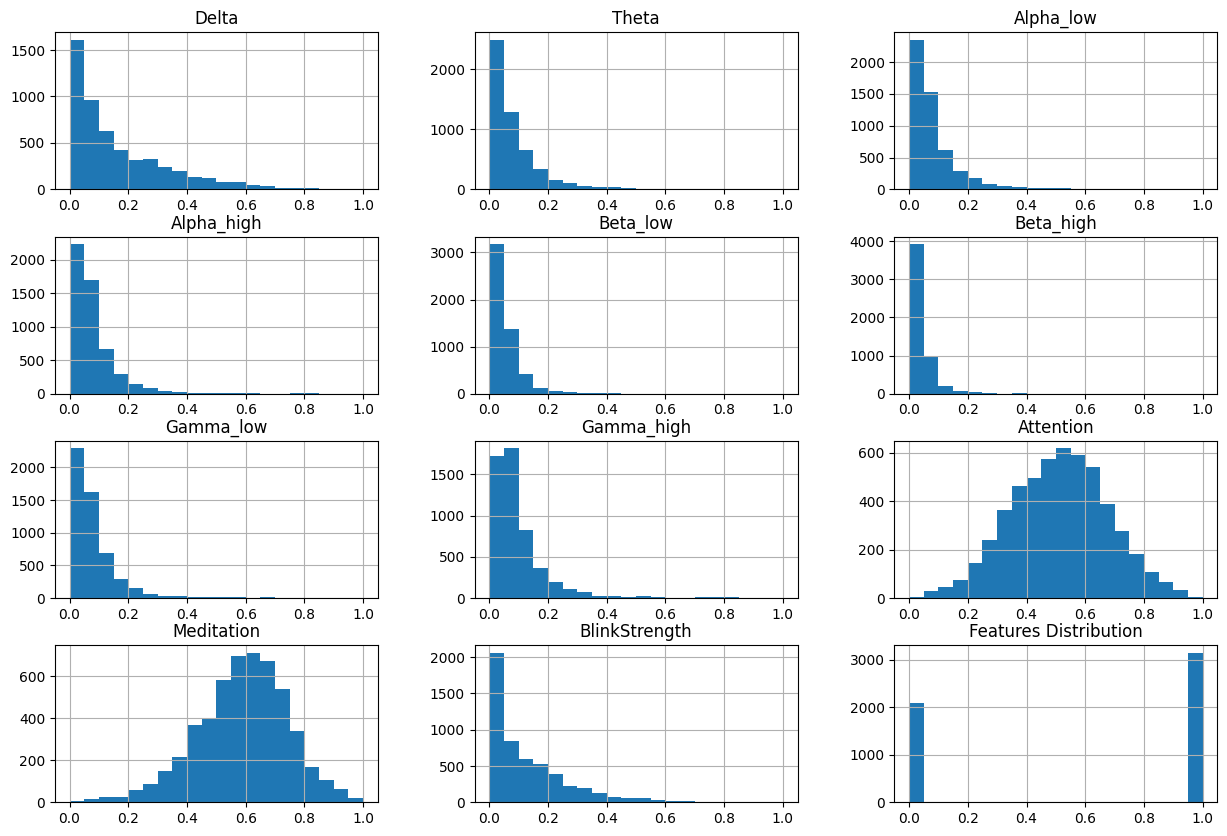

In [258]:
scaled_dataset.hist(figsize=(15,10), bins = 20)
plt.title("Features Distribution")
plt.show()

In [259]:
X3 = torch.tensor(transformed_dataset.loc[:, "Delta_log": "Meditation"].values, dtype=torch.float32)
y3 = torch.tensor(transformed_dataset.Flag.values, dtype=torch.float32)

X_train_3, X_test_3, X_val_3, y_train_3, y_test_3, y_val_3 = split_data(X3, y3, test_size=0.3, random_state=1)

y_train_3 = y_train_3.unsqueeze(1)
y_val_3 = y_val_3.unsqueeze(1)
y_test_3 = y_test_3.unsqueeze(1)

train_dataloader_3 = create_dataloader(X_train_3, y_train_3)
val_dataloader_3 = create_dataloader(X_val_3, y_val_3)
test_dataloader_3 = create_dataloader(X_test_3, y_test_3)

DataLoader length: 115 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32


In [260]:
flag_model_2_with_scaled_data = FlagModel2(11, 32, 1).to(device)
optimizer = torch.optim.Adam(params=flag_model_2_with_scaled_data.parameters(), lr=LEARNING_RATE)

In [261]:
model_3_loss_and_acc = train(model=flag_model_2_with_scaled_data,
      train_data=train_dataloader_3,
      test_data=val_dataloader_3,
      loss_fn=loss_fn,
      optimizer=optimizer,
      # accuracy_fn=accuracy_fn,
      epochs=EPOCHS)

  4%|▍         | 2/50 [00:00<00:09,  4.97it/s]


Epoch: 1 | Train Loss: 0.02040 | Train Acc: 56.45777% | Test loss: 0.020484895687999993 | Test Acc: 56.16264%


  6%|▌         | 3/50 [00:00<00:13,  3.56it/s]


Epoch: 2 | Train Loss: 0.02038 | Train Acc: 56.37602% | Test loss: 0.020544224727562756 | Test Acc: 57.68742%


  8%|▊         | 4/50 [00:01<00:14,  3.16it/s]


Epoch: 3 | Train Loss: 0.02035 | Train Acc: 58.06540% | Test loss: 0.0205523995765434 | Test Acc: 55.40025%


 10%|█         | 5/50 [00:01<00:14,  3.03it/s]


Epoch: 4 | Train Loss: 0.02029 | Train Acc: 57.27520% | Test loss: 0.020540024682860515 | Test Acc: 53.24015%


 14%|█▍        | 7/50 [00:02<00:15,  2.87it/s]


Epoch: 6 | Train Loss: 0.02027 | Train Acc: 57.35695% | Test loss: 0.02046273290883783 | Test Acc: 54.63787%


 16%|█▌        | 8/50 [00:02<00:14,  2.80it/s]


Epoch: 7 | Train Loss: 0.02023 | Train Acc: 58.09264% | Test loss: 0.02059368393472674 | Test Acc: 56.92503%


 18%|█▊        | 9/50 [00:02<00:14,  2.77it/s]


Epoch: 8 | Train Loss: 0.02024 | Train Acc: 58.06540% | Test loss: 0.020588495452643348 | Test Acc: 53.49428%


 20%|██        | 10/50 [00:03<00:14,  2.73it/s]


Epoch: 9 | Train Loss: 0.02022 | Train Acc: 58.74659% | Test loss: 0.0205763018722001 | Test Acc: 51.33418%


 24%|██▍       | 12/50 [00:04<00:13,  2.72it/s]


Epoch: 11 | Train Loss: 0.02022 | Train Acc: 57.73842% | Test loss: 0.020591108589947907 | Test Acc: 52.60483%


 26%|██▌       | 13/50 [00:04<00:13,  2.71it/s]


Epoch: 12 | Train Loss: 0.02020 | Train Acc: 58.01090% | Test loss: 0.02047983679111001 | Test Acc: 56.79797%


 28%|██▊       | 14/50 [00:04<00:13,  2.72it/s]


Epoch: 13 | Train Loss: 0.02020 | Train Acc: 58.82834% | Test loss: 0.020493011841174153 | Test Acc: 59.59339%


 30%|███       | 15/50 [00:05<00:12,  2.70it/s]


Epoch: 14 | Train Loss: 0.02022 | Train Acc: 57.46594% | Test loss: 0.020459792892693566 | Test Acc: 52.60483%


 34%|███▍      | 17/50 [00:05<00:12,  2.71it/s]


Epoch: 16 | Train Loss: 0.02014 | Train Acc: 58.63760% | Test loss: 0.020535654382451213 | Test Acc: 54.25667%


 36%|███▌      | 18/50 [00:06<00:11,  2.71it/s]


Epoch: 17 | Train Loss: 0.02015 | Train Acc: 58.33787% | Test loss: 0.02033549282117599 | Test Acc: 56.67090%


 38%|███▊      | 19/50 [00:06<00:11,  2.71it/s]


Epoch: 18 | Train Loss: 0.02008 | Train Acc: 59.80926% | Test loss: 0.020502332053614694 | Test Acc: 54.00254%


 40%|████      | 20/50 [00:07<00:11,  2.70it/s]


Epoch: 19 | Train Loss: 0.02013 | Train Acc: 58.80109% | Test loss: 0.020628351268501717 | Test Acc: 53.49428%


 44%|████▍     | 22/50 [00:07<00:10,  2.71it/s]


Epoch: 21 | Train Loss: 0.02009 | Train Acc: 60.02725% | Test loss: 0.02038488825818635 | Test Acc: 59.21220%


 46%|████▌     | 23/50 [00:08<00:09,  2.71it/s]


Epoch: 22 | Train Loss: 0.02006 | Train Acc: 59.59128% | Test loss: 0.020410981384287038 | Test Acc: 57.17916%


 48%|████▊     | 24/50 [00:08<00:09,  2.68it/s]


Epoch: 23 | Train Loss: 0.02001 | Train Acc: 60.05450% | Test loss: 0.020381068032154438 | Test Acc: 59.97459%


 50%|█████     | 25/50 [00:08<00:09,  2.70it/s]


Epoch: 24 | Train Loss: 0.02007 | Train Acc: 60.79019% | Test loss: 0.020359840144650605 | Test Acc: 57.30623%


 54%|█████▍    | 27/50 [00:09<00:08,  2.59it/s]


Epoch: 26 | Train Loss: 0.02007 | Train Acc: 60.10899% | Test loss: 0.02033094181341925 | Test Acc: 57.30623%


 56%|█████▌    | 28/50 [00:10<00:08,  2.64it/s]


Epoch: 27 | Train Loss: 0.02000 | Train Acc: 60.08174% | Test loss: 0.020338613393194642 | Test Acc: 58.57687%


 58%|█████▊    | 29/50 [00:10<00:07,  2.65it/s]


Epoch: 28 | Train Loss: 0.02000 | Train Acc: 61.25341% | Test loss: 0.02065957024258004 | Test Acc: 52.22363%


 60%|██████    | 30/50 [00:10<00:07,  2.66it/s]


Epoch: 29 | Train Loss: 0.02000 | Train Acc: 60.81744% | Test loss: 0.02044267439327216 | Test Acc: 55.14612%


 64%|██████▍   | 32/50 [00:11<00:06,  2.73it/s]


Epoch: 31 | Train Loss: 0.02000 | Train Acc: 60.27248% | Test loss: 0.02032361332009981 | Test Acc: 59.21220%


 66%|██████▌   | 33/50 [00:11<00:06,  2.73it/s]


Epoch: 32 | Train Loss: 0.01998 | Train Acc: 60.38147% | Test loss: 0.020490136504021806 | Test Acc: 56.28971%


 68%|██████▊   | 34/50 [00:12<00:05,  2.74it/s]


Epoch: 33 | Train Loss: 0.01997 | Train Acc: 60.81744% | Test loss: 0.02036326033036015 | Test Acc: 57.05210%


 70%|███████   | 35/50 [00:12<00:05,  2.73it/s]


Epoch: 34 | Train Loss: 0.01994 | Train Acc: 60.81744% | Test loss: 0.0207034063914831 | Test Acc: 59.72046%


 74%|███████▍  | 37/50 [00:13<00:04,  2.74it/s]


Epoch: 36 | Train Loss: 0.01999 | Train Acc: 60.13624% | Test loss: 0.02031148972020519 | Test Acc: 56.79797%


 76%|███████▌  | 38/50 [00:13<00:04,  2.73it/s]


Epoch: 37 | Train Loss: 0.01991 | Train Acc: 61.36240% | Test loss: 0.02028929566185841 | Test Acc: 57.68742%


 78%|███████▊  | 39/50 [00:14<00:04,  2.72it/s]


Epoch: 38 | Train Loss: 0.01990 | Train Acc: 60.95368% | Test loss: 0.020311341276617184 | Test Acc: 56.92503%


 80%|████████  | 40/50 [00:14<00:03,  2.70it/s]


Epoch: 39 | Train Loss: 0.01997 | Train Acc: 60.38147% | Test loss: 0.020283238633312144 | Test Acc: 57.43329%


 84%|████████▍ | 42/50 [00:15<00:02,  2.75it/s]


Epoch: 41 | Train Loss: 0.01990 | Train Acc: 61.36240% | Test loss: 0.02027843413540793 | Test Acc: 56.54384%


 86%|████████▌ | 43/50 [00:15<00:02,  2.74it/s]


Epoch: 42 | Train Loss: 0.01992 | Train Acc: 60.79019% | Test loss: 0.020258764829841625 | Test Acc: 60.35578%


 88%|████████▊ | 44/50 [00:15<00:02,  2.67it/s]


Epoch: 43 | Train Loss: 0.01985 | Train Acc: 62.17984% | Test loss: 0.020215101284477885 | Test Acc: 56.79797%


 90%|█████████ | 45/50 [00:16<00:01,  2.67it/s]


Epoch: 44 | Train Loss: 0.01985 | Train Acc: 62.39782% | Test loss: 0.02017341915806791 | Test Acc: 56.79797%


 94%|█████████▍| 47/50 [00:17<00:01,  2.65it/s]


Epoch: 46 | Train Loss: 0.01987 | Train Acc: 61.47139% | Test loss: 0.020478645834262368 | Test Acc: 60.22872%


 96%|█████████▌| 48/50 [00:17<00:00,  2.66it/s]


Epoch: 47 | Train Loss: 0.01992 | Train Acc: 61.30790% | Test loss: 0.02018871301314125 | Test Acc: 56.54384%


 98%|█████████▊| 49/50 [00:17<00:00,  2.50it/s]


Epoch: 48 | Train Loss: 0.01982 | Train Acc: 62.15259% | Test loss: 0.020104242476908042 | Test Acc: 60.48285%


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Epoch: 49 | Train Loss: 0.01975 | Train Acc: 62.86104% | Test loss: 0.020217645728754726 | Test Acc: 59.97459%

Training was done in 49.00147 seconds


In [262]:
model_1_loss_and_acc.head()

,train_loss,train_acc,test_loss,test_acc,f1_score
0,0.022454,59.618529,0.021907,62.261753,0.383712
1,0.022490,59.564033,0.021907,62.261753,0.383712
2,0.022486,59.564033,0.021962,62.261753,0.383712
3,0.022497,59.564033,0.022016,62.261753,0.383712
4,0.022474,59.564033,0.021907,62.261753,0.383712


In [263]:
model_2_loss_and_acc.head()

,train_loss,train_acc,test_loss,test_acc,f1_score
0,0.020738,54.659401,0.020494,54.256671,0.541197
1,0.020507,55.803815,0.020443,55.146125,0.551435
2,0.020402,56.267030,0.020548,51.588310,0.507279
3,0.020346,56.566757,0.020489,53.621347,0.534759
4,0.020312,56.920981,0.020485,59.847522,0.585546


In [264]:
model_3_loss_and_acc.head()

,train_loss,train_acc,test_loss,test_acc,f1_score
0,0.020611,53.732970,0.020674,58.831004,0.540860
1,0.020399,56.457766,0.020485,56.162643,0.558889
2,0.020382,56.376022,0.020544,57.687421,0.563451
3,0.020355,58.065395,0.020552,55.400254,0.553354
4,0.020291,57.275204,0.020540,53.240152,0.529575


In [265]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_metrics(metrics, model_name):
   x_plot = list(range(len(metrics)))

   fig = make_subplots(rows=3, cols=1)

   fig.add_trace(go.Scatter(y=metrics['train_loss'], mode='lines', name='train loss'), row=1, col=1)
   fig.add_trace(go.Scatter(y=metrics['test_loss'], mode='lines', name='Validation loss'), row=1, col=1)
   fig.update_layout(height=600, width=600, title_text="Loss Value")

   fig.add_trace(go.Scatter(y=metrics['train_acc'], mode='lines', name='train accuracy'), row=2, col=1)
   fig.add_trace(go.Scatter(y=metrics['test_acc'], mode='lines', name='Validation accuracy'), row=2, col=1)
   fig.update_layout(height=600, width=600, title_text=model_name)
   
   fig.add_trace(go.Scatter(y=metrics['f1_score'], mode='lines', name='f1 score'), row=3, col=1)


   fig.show()


In [266]:
plot_metrics(model_1_loss_and_acc, "Model 1")

In [267]:
plot_metrics(model_2_loss_and_acc, "Model 2")

In [268]:
plot_metrics(model_3_loss_and_acc, "Model 3")

In [269]:
# def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
#     preds = []
#     model.eval()
#     with torch.inference_mode():
#         for sample in data:
#             # sample = sample.unsqueeze(dim=1).to(device) # Add an extra dimension and send sample to device

#             # Forward pass (model outputs raw logit)
#             logits = model(sample)
#             pred = torch.round(torch.sigmoid(logits))

#             # Get pred_prob off GPU for further calculations
#             preds.append(pred.cpu())
            
#     # Stack the preds to turn list into a tensor
#     return torch.stack(preds)

In [270]:
# print(make_predictions())
def test_predict(model, test_data):
    model.eval()
    with torch.inference_mode():
        model_preds = torch.round(model(test_data))
    return model_preds


def predictions_to_dataframe(preds):
    results = preds.argmax(dim=1).cpu().numpy()

    sample_submission = pd.DataFrame(results, columns=['class'])
    sample_submission.index.name = "index"
    # print(sample_submission)
    return sample_submission

In [271]:
model_1_preds, model_2_preds, model_3_preds = test_predict(flag_model_1, torch.tensor(X_test).type(torch.float32)), test_predict(flag_model_2, torch.tensor(X_test).type(torch.float32)), test_predict(flag_model_2_with_scaled_data, torch.tensor(X_test).type(torch.float32))

/tmp/ipykernel_24794/3058219584.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [272]:
zeros = 0
non_zeros = 0
for i in model_3_preds:
    if i == 0:
        zeros += 1
    elif i==1:
        non_zeros += 1        

print(zeros, non_zeros)
print(model_1_preds)

787 0
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],


In [273]:
print(f"Model 1 acc: {accuracy_fn(y_test, model_1_preds)}")
print(f"Model 2 acc: {accuracy_fn(y_test, model_2_preds)}")
print(f"Model 2 with data scaling acc: {accuracy_fn(y_test, model_3_preds)}")

Model 1 acc: 60.482846251588306
Model 2 acc: 43.58322744599746
Model 2 with data scaling acc: 39.64421855146124


# using standard scaler

In [274]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = dataset.drop(columns=["Flag"])
# scaled_features = scaler.fit_transform(normal_features)

In [275]:
features_np = features.values
X = torch.tensor(features_np, dtype=torch.float32)
y = torch.tensor(dataset["Flag"].values, dtype=torch.float32)

In [276]:
model_1_scaled_loss_and_acc = pd.DataFrame()
model_1_scaled_loss_and_acc['train_loss'] = []
model_1_scaled_loss_and_acc['train_acc'] = []
model_1_scaled_loss_and_acc['test_loss'] = []
model_1_scaled_loss_and_acc['test_acc'] = []
model_1_scaled_loss_and_acc['f1_score'] = []

In [277]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train_4, y_val_4, y_test_4 = split_data(X, y, 0.4, 1)
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.fit_transform(X_test_scaled)
X_val_scaled = scaler.fit_transform(X_val_scaled)

X_train_scaled.shape

(3670, 11)

In [278]:
y_train_4 = y_train_4.unsqueeze(1)
y_val_4 = y_val_4.unsqueeze(1)
y_test_4 = y_test_4.unsqueeze(1)

y_train.shape, y_test.shape, y_val.shape

(torch.Size([3670, 1]), torch.Size([787, 1]), torch.Size([787, 1]))

In [279]:
X_train_scaled = torch.from_numpy(X_train_scaled).float()
X_val_scaled = torch.from_numpy(X_val_scaled).float()
X_test_scaled = torch.from_numpy(X_test_scaled).float()

In [280]:
train_dataloader = create_dataloader(X_train_scaled, y_train_4)
test_dataloader = create_dataloader(X_test_scaled, y_test_4)
val_dataloader = create_dataloader(X_val_scaled, y_val_4)

DataLoader length: 115 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32
DataLoader length: 25 | Batch Size: 32


In [281]:
flag_model_1_2 = FlagModel(11, 32, 1)
optimizer = torch.optim.Adam(params=flag_model_1_2.parameters(), lr=0.003)
model_1_scaled_loss_and_acc = train(model=flag_model_1_2,
                                    train_data=train_dataloader,
                                    test_data=val_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    # accuracy_fn=accuracy_fn,
                                    epochs=EPOCHS)

  2%|▏         | 1/50 [00:00<00:20,  2.41it/s]

  4%|▍         | 2/50 [00:00<00:23,  2.04it/s]


Epoch: 1 | Train Loss: 0.01945 | Train Acc: 63.48774% | Test loss: 0.019405648093362926 | Test Acc: 68.86912%


  6%|▌         | 3/50 [00:01<00:22,  2.08it/s]


Epoch: 2 | Train Loss: 0.01911 | Train Acc: 68.36512% | Test loss: 0.01918060821983987 | Test Acc: 67.59848%


  8%|▊         | 4/50 [00:01<00:20,  2.20it/s]


Epoch: 3 | Train Loss: 0.01889 | Train Acc: 70.00000% | Test loss: 0.018983472938610305 | Test Acc: 68.61499%


 10%|█         | 5/50 [00:02<00:18,  2.41it/s]


Epoch: 4 | Train Loss: 0.01876 | Train Acc: 70.27248% | Test loss: 0.01902468655887977 | Test Acc: 69.12325%


 14%|█▍        | 7/50 [00:02<00:16,  2.64it/s]


Epoch: 6 | Train Loss: 0.01866 | Train Acc: 71.17166% | Test loss: 0.018844460592790966 | Test Acc: 70.39390%


 16%|█▌        | 8/50 [00:03<00:15,  2.66it/s]


Epoch: 7 | Train Loss: 0.01864 | Train Acc: 71.52589% | Test loss: 0.018884492117386156 | Test Acc: 69.25032%


 18%|█▊        | 9/50 [00:03<00:15,  2.64it/s]


Epoch: 8 | Train Loss: 0.01858 | Train Acc: 71.66213% | Test loss: 0.01891085528206492 | Test Acc: 70.77510%


 20%|██        | 10/50 [00:04<00:15,  2.57it/s]


Epoch: 9 | Train Loss: 0.01857 | Train Acc: 71.82561% | Test loss: 0.01886748790438021 | Test Acc: 70.13977%


 24%|██▍       | 12/50 [00:05<00:16,  2.28it/s]


Epoch: 11 | Train Loss: 0.01848 | Train Acc: 72.91553% | Test loss: 0.01883258487854101 | Test Acc: 70.13977%


 26%|██▌       | 13/50 [00:05<00:16,  2.21it/s]


Epoch: 12 | Train Loss: 0.01851 | Train Acc: 72.17984% | Test loss: 0.01890082424447376 | Test Acc: 69.88564%


 28%|██▊       | 14/50 [00:05<00:15,  2.27it/s]


Epoch: 13 | Train Loss: 0.01847 | Train Acc: 72.61580% | Test loss: 0.018906814549141948 | Test Acc: 72.42694%


 30%|███       | 15/50 [00:06<00:14,  2.39it/s]


Epoch: 14 | Train Loss: 0.01842 | Train Acc: 73.18801% | Test loss: 0.01884291496179913 | Test Acc: 69.37738%


 34%|███▍      | 17/50 [00:07<00:13,  2.48it/s]


Epoch: 16 | Train Loss: 0.01840 | Train Acc: 73.02452% | Test loss: 0.018821107538409883 | Test Acc: 69.63151%


 36%|███▌      | 18/50 [00:07<00:12,  2.55it/s]


Epoch: 17 | Train Loss: 0.01836 | Train Acc: 73.62398% | Test loss: 0.018829965190027085 | Test Acc: 69.88564%


 38%|███▊      | 19/50 [00:07<00:12,  2.54it/s]


Epoch: 18 | Train Loss: 0.01831 | Train Acc: 73.70572% | Test loss: 0.018799535504138758 | Test Acc: 71.15629%


 40%|████      | 20/50 [00:08<00:11,  2.54it/s]


Epoch: 19 | Train Loss: 0.01829 | Train Acc: 73.97820% | Test loss: 0.018761621118349222 | Test Acc: 71.02922%


 44%|████▍     | 22/50 [00:09<00:10,  2.58it/s]


Epoch: 21 | Train Loss: 0.01830 | Train Acc: 73.84196% | Test loss: 0.018916775227501854 | Test Acc: 68.86912%


 46%|████▌     | 23/50 [00:09<00:10,  2.62it/s]


Epoch: 22 | Train Loss: 0.01825 | Train Acc: 74.33243% | Test loss: 0.01877736829438991 | Test Acc: 70.39390%


 48%|████▊     | 24/50 [00:09<00:09,  2.62it/s]


Epoch: 23 | Train Loss: 0.01821 | Train Acc: 74.85014% | Test loss: 0.018706880424649772 | Test Acc: 72.29987%


 50%|█████     | 25/50 [00:10<00:09,  2.62it/s]


Epoch: 24 | Train Loss: 0.01823 | Train Acc: 74.65940% | Test loss: 0.01873435074371183 | Test Acc: 71.53748%


 54%|█████▍    | 27/50 [00:10<00:08,  2.59it/s]


Epoch: 26 | Train Loss: 0.01819 | Train Acc: 75.17711% | Test loss: 0.018818924660300967 | Test Acc: 72.42694%


 56%|█████▌    | 28/50 [00:11<00:08,  2.65it/s]


Epoch: 27 | Train Loss: 0.01821 | Train Acc: 74.63215% | Test loss: 0.018824026802746436 | Test Acc: 70.01271%


 58%|█████▊    | 29/50 [00:11<00:08,  2.62it/s]


Epoch: 28 | Train Loss: 0.01815 | Train Acc: 75.23161% | Test loss: 0.01876797404949668 | Test Acc: 72.55400%


 60%|██████    | 30/50 [00:12<00:07,  2.60it/s]


Epoch: 29 | Train Loss: 0.01813 | Train Acc: 75.55858% | Test loss: 0.01892682633527201 | Test Acc: 71.79161%


 64%|██████▍   | 32/50 [00:12<00:06,  2.67it/s]


Epoch: 31 | Train Loss: 0.01809 | Train Acc: 75.91281% | Test loss: 0.01882014432129139 | Test Acc: 71.91868%


 66%|██████▌   | 33/50 [00:13<00:07,  2.41it/s]


Epoch: 32 | Train Loss: 0.01807 | Train Acc: 75.85831% | Test loss: 0.01886240348428147 | Test Acc: 72.17281%


 68%|██████▊   | 34/50 [00:13<00:06,  2.45it/s]


Epoch: 33 | Train Loss: 0.01814 | Train Acc: 75.14986% | Test loss: 0.01882970143758054 | Test Acc: 70.90216%


 70%|███████   | 35/50 [00:14<00:06,  2.47it/s]


Epoch: 34 | Train Loss: 0.01813 | Train Acc: 75.36785% | Test loss: 0.018721109462057014 | Test Acc: 72.29987%


 74%|███████▍  | 37/50 [00:14<00:04,  2.60it/s]


Epoch: 36 | Train Loss: 0.01809 | Train Acc: 75.50409% | Test loss: 0.018648045793118895 | Test Acc: 72.42694%


 76%|███████▌  | 38/50 [00:15<00:04,  2.66it/s]


Epoch: 37 | Train Loss: 0.01804 | Train Acc: 76.37602% | Test loss: 0.018779535229960422 | Test Acc: 71.66455%


 78%|███████▊  | 39/50 [00:15<00:04,  2.62it/s]


Epoch: 38 | Train Loss: 0.01801 | Train Acc: 76.21253% | Test loss: 0.01873055467763123 | Test Acc: 71.53748%


 80%|████████  | 40/50 [00:15<00:03,  2.62it/s]


Epoch: 39 | Train Loss: 0.01806 | Train Acc: 76.43052% | Test loss: 0.018737952318397533 | Test Acc: 73.06226%


 84%|████████▍ | 42/50 [00:16<00:02,  2.69it/s]


Epoch: 41 | Train Loss: 0.01796 | Train Acc: 76.94823% | Test loss: 0.018768024490021993 | Test Acc: 72.04574%


 86%|████████▌ | 43/50 [00:17<00:02,  2.64it/s]


Epoch: 42 | Train Loss: 0.01799 | Train Acc: 76.64850% | Test loss: 0.018811688186858782 | Test Acc: 71.66455%


 88%|████████▊ | 44/50 [00:17<00:02,  2.63it/s]


Epoch: 43 | Train Loss: 0.01798 | Train Acc: 76.56676% | Test loss: 0.01859306512824159 | Test Acc: 73.06226%


 90%|█████████ | 45/50 [00:17<00:01,  2.64it/s]


Epoch: 44 | Train Loss: 0.01799 | Train Acc: 76.67575% | Test loss: 0.018674986941084323 | Test Acc: 73.31639%


 94%|█████████▍| 47/50 [00:18<00:01,  2.68it/s]


Epoch: 46 | Train Loss: 0.01792 | Train Acc: 76.89373% | Test loss: 0.018634395079812675 | Test Acc: 72.80813%


 96%|█████████▌| 48/50 [00:18<00:00,  2.76it/s]


Epoch: 47 | Train Loss: 0.01788 | Train Acc: 77.13896% | Test loss: 0.01884906294991131 | Test Acc: 71.79161%


 98%|█████████▊| 49/50 [00:19<00:00,  2.57it/s]


Epoch: 48 | Train Loss: 0.01786 | Train Acc: 77.38420% | Test loss: 0.01865637007026236 | Test Acc: 73.06226%


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


Epoch: 49 | Train Loss: 0.01792 | Train Acc: 77.02997% | Test loss: 0.018733385708916746 | Test Acc: 72.42694%

Training was done in 69.53777 seconds


In [282]:
model_4_preds = test_predict(flag_model_1_2, torch.tensor(X_test_scaled).type(torch.float32))

/tmp/ipykernel_24794/3878065201.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [283]:
zeros, non_zeros = 0, 0
for i in model_4_preds:
    if i == 0:
        zeros += 1
    elif i==1:
        non_zeros += 1      
        
print(zeros, non_zeros)

405 382


In [286]:
print(f"Model 1 with data standard scaling acc: {accuracy_fn(y_test_4, model_4_preds)}")

Model 1 with data standard scaling acc: 70.01270648030496


In [285]:
plot_metrics(model_1_scaled_loss_and_acc, "Model 1 with standard scaled data")